## Build a Neural Network using ChemML

We use a sample dataset from ChemML library which has the SMILES codes and Dragon molecular descriptors for 500 small organic molecules with their densities in $kg/m^3$. 

In [2]:
import warnings
warnings.filterwarnings("ignore")

from chemml.datasets import load_organic_density
molecules, target, dragon_subset = load_organic_density()

After scaling the data using the Scikit-learn `StandardScaler` function, we use a 1:3 split for training:testing data. 

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

xscale = StandardScaler()
yscale = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(dragon_subset.values, target.values, test_size=0.25, random_state=42)

X_train = xscale.fit_transform(X_train)
X_test = xscale.transform(X_test)
y_train = yscale.fit_transform(y_train)

### Fit the `chemml.model.MLP` model to the training data

In [5]:
from chemml.models import MLP 

mlp = MLP(nhidden=3, nneurons=[32,64,128],
          activations=['relu','relu','relu'],
          nepochs=20,batch_size=50,loss='mean_squared_error',
          regression='True',nclasses=None,layer_config_file=None,
          opt_config=None)

mlp.fit(X = X_train, y = y_train)

Epoch 1/20
8/8 [==============================] - 0s 2ms/step - loss: 0.7672
Epoch 2/20
8/8 [==============================] - 0s 2ms/step - loss: 0.2712
Epoch 3/20
8/8 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 4/20
8/8 [==============================] - 0s 2ms/step - loss: 0.1710
Epoch 5/20
8/8 [==============================] - 0s 2ms/step - loss: 0.1697
Epoch 6/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0862
Epoch 7/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0564
Epoch 8/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0504
Epoch 9/20
8/8 [==============================] - 0s 3ms/step - loss: 0.0365
Epoch 10/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0352
Epoch 11/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 12/20
8/8 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 13/20
8/8 [==============================] - 0s 2ms/step - loss: 0.

### Saving the ChemML model

In [6]:
mlp.save(path=".",filename="saved_MLP")

File saved as ./saved_MLP_chemml_model.csv


### Loading the saved ChemML model 

In [7]:
loaded_MLP = MLP()
loaded_MLP = loaded_MLP.load("./saved_MLP_chemml_model.csv")
print(type(loaded_MLP))

<class 'chemml.models.keras.mlp.MLP'>


### Predict the densities for the test data

In [8]:
import numpy as np

y_pred = loaded_MLP.predict(X_test)
y_pred = yscale.inverse_transform(y_pred.reshape(-1,1))

### Evaluate model performance using `chemml.utils.regression_metrics`

In [9]:
from chemml.utils import regression_metrics

# For the regression_metrics function the inputs must have the same data type
metrics_df = regression_metrics(y_test, y_pred)
print("Metrics: \n")
print(metrics_df[["MAE", "RMSE", "MAPE", "r_squared"]])

Metrics: 

         MAE      RMSE      MAPE  r_squared
0  11.354159  15.53072  0.886087    0.97493


### Plot actual vs. predicted values

The Plot has been saved at:  ./images/Parity.png


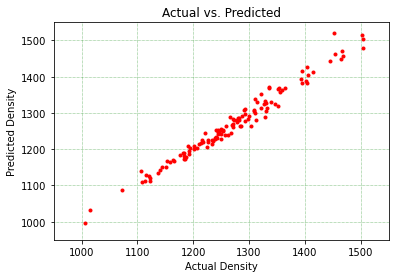

In [10]:
from chemml.visualization import scatter2D, SavePlot, decorator
import pandas as pd
%matplotlib inline
df = pd.DataFrame()
df["Actual"] = y_test.reshape(-1,)
df["Predicted"] = y_pred.reshape(-1,)
sc = scatter2D('r', marker='.')
fig = sc.plot(dfx=df, dfy=df, x="Actual", y="Predicted")

dec = decorator(title='Actual vs. Predicted',xlabel='Actual Density', ylabel='Predicted Density',
                xlim= (950,1550), ylim=(950,1550), grid=True, 
                grid_color='g', grid_linestyle=':', grid_linewidth=0.5)
fig = dec.fit(fig)
# print(type(fig))
sa=SavePlot(filename='Parity',output_directory='images',
            kwargs={'facecolor':'w','dpi':330,'pad_inches':0.1, 'bbox_inches':'tight'})
sa.save(obj=fig)
fig.show()

### If the keras model is required ...

In [11]:
keras_mlp = mlp.get_keras_model()

In [12]:
print(type(keras_mlp))
print(keras_mlp.summary())

<class 'keras.engine.sequential.Sequential'>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,993
Trainable params: 16,993
Non-trainable params: 0
_________________________________________________________________
None


### Sometimes you may need the keras model without the output layer (for e.g., for transfer learning)

In [13]:
keras_mlp_no_output = mlp.get_keras_model(include_output=False)
print(type(keras_mlp_no_output))
print(keras_mlp_no_output.summary())

<class 'keras.engine.functional.Functional'>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
Total params: 16,864
Trainable params: 16,864
Non-trainable params: 0
_________________________________________________________________
None
